In [1]:
import scanpy as sc
from torch.utils.data import Dataset, DataLoader
import torch
from flecs.utils import set_seed
from tqdm import tqdm
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import os
from flecs.utils import get_project_root
from flecs.sc.model import ProteinLevelPop, GRNCellPop
from flecs.trajectory import simulate_deterministic_trajectory
import anndata as ad

scv.set_figure_params('scvelo')  # for beautified visualization
plt.rcParams["figure.figsize"] = (16,8)

## Load data

In [2]:
set_seed(0)
adata = sc.read_h5ad(os.path.join(get_project_root(),
                                  "figure4", "processed", "adata_processed_with_obs_pseudotime_paths.h5ad")
                     )

In [3]:
len(adata)

16835

In [4]:
adata

AnnData object with n_obs × n_vars = 16835 × 4000
    obs: 'cell_barcode', 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'n_counts_all', 'S_score', 'G2M_score', 'phase', 'dpt_pseudotime', 'pseudotime_quantile', 'n_counts'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'gene_id', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'g1_s_obs_shortest_paths', 'g2_g1_obs_shortest_paths', 'gene_colors', 'hvg', 'iroot', 'log1p', 'neighbors', 'pca', 'phase_colors', 's_g2_obs_shortest_paths', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
    varp: 'grn_adj_mat'

In [5]:
adata = adata[adata.obs["gene"] == "non-targeting"].copy()

## Model

In [6]:
for i in range(1, 4000):
    if adata.shape[0] % i == 0:
        print(i)

1
2
3739


In [7]:
batch_size = adata.shape[0] // 3739

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
mycellpop = GRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=0, use_2nd_order_interactions=False).to(device)

## Load weights

In [10]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "figure4", "logs", "trained_mycellpop_jan_02_3.pt"), 
                                map_location=torch.device('cpu'))

In [11]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

In [12]:
mycellpop[('gene', 'regulates', 'gene')]

EdgeSet(3323674 edges, edge attributes: ['weight', 'simple_conv_weights'])

In [13]:
mycellpop[('gene', 'regulates', 'gene')].simple_conv_weights.shape

torch.Size([1, 3323674, 1])

## Plotting

In [14]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
highly_var_gene_list = list(adata.var.iloc[np.where(adata.X.std(axis=0) > .1)[0]].index)

In [15]:
len(highly_var_gene_list)

1175

In [16]:
with torch.no_grad():

    g1_s_velocities = []

    for i in tqdm(range(adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(adata.X[i*batch_size: (i + 1)*batch_size, :, None]).to(device)
        velocity = mycellpop.get_derivatives(gene_expr)
        g1_s_velocities.append(velocity)

g1_s_velocities = torch.cat(g1_s_velocities).cpu().numpy()[:, :, 0]
adata.layers["velocity"] = g1_s_velocities
adata.layers["X"] = adata.X

100%|██████████| 3739/3739 [02:33<00:00, 24.39it/s]


In [17]:
scv.tl.velocity_graph(adata, xkey="X", gene_subset=highly_var_gene_list, 
                      n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/7478 [00:00<?, ?cells/s]

    finished (0:00:36) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


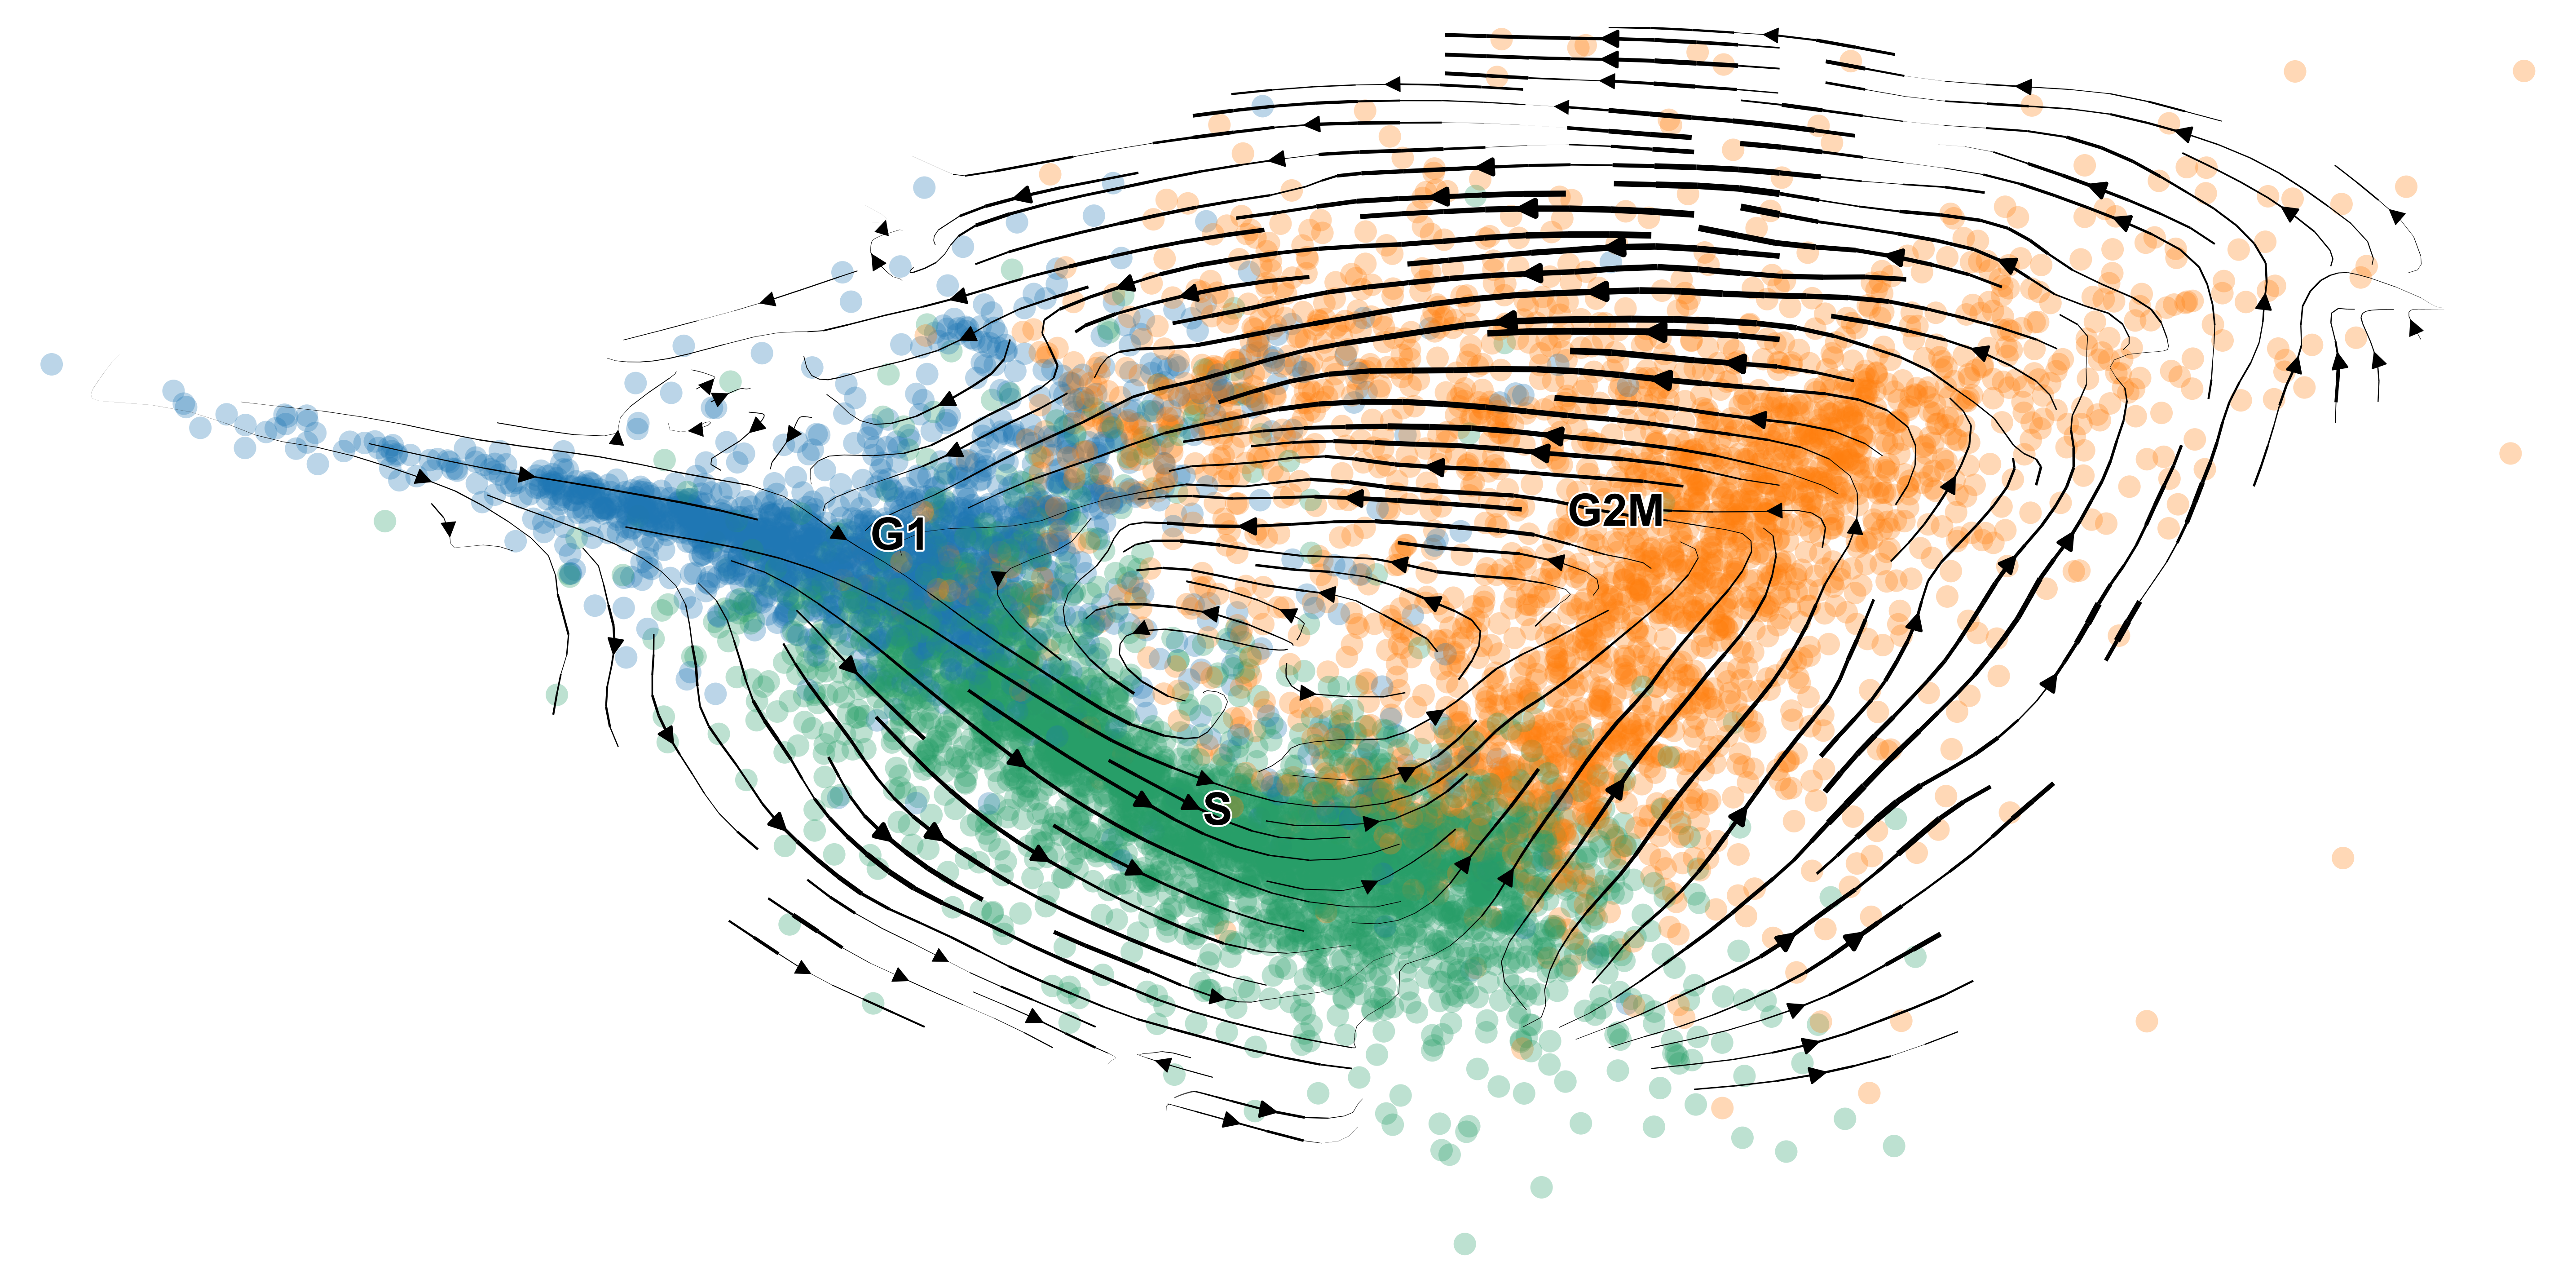

In [26]:
plt.rcParams["figure.figsize"] = (12,6)
scv.pl.velocity_embedding_stream(adata, basis='umap', color="phase", layer="obs", title="", dpi=300)